# ACS Data Collection
- Use Census API to collect sociodemographic data for across multiple states.
- States: CA, CT, LA, PA, TN, TX, VT, WA
- Demographic characteristics: Total population, % BIPOC, % Black, % Hispanic, % Indigenous, % AAPI, median age, median income, % male, % college educated

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import censusdata
import geopandas as gpd
import time

In [38]:
def get_census_data(tables, state, county='*', year=2019):

    # Download the data
    data = censusdata.download('acs5', year,  # Use 2019 ACS 5-year estimates
                               censusdata.censusgeo([('state', state), ('county', county), ('tract', '*')]),
                               list(tables.keys()))

    # Rename the column
    data.rename(columns=tables, inplace=True)

    # Extract information from the first column
    data['Name'] = data.index.to_series().apply(lambda x: x.name)
    data['SummaryLevel'] = data.index.to_series().apply(lambda x: x.sumlevel())
    data['State'] = data.index.to_series().apply(lambda x: x.geo[0][1])
    data['County'] = data.index.to_series().apply(lambda x: x.geo[1][1])
    data['Tract'] = data.index.to_series().apply(lambda x: x.geo[2][1])
    data.reset_index(drop=True, inplace=True)
    data = data[['Tract','Name', 'State']+list(tables.values())].set_index('Tract')
    return data

def get_census_tract_geom(state_fips):

    # find state and county fips here: https://www.census.gov/geographies/reference-files/2017/demo/popest/2017-fips.html
    
    # Download the census tract shapefiles
    tracts = gpd.read_file(f'https://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_{state_fips}_tract.zip')

    # set index as tract
    tracts = tracts.rename(columns={'TRACTCE':'Tract'}).set_index('Tract')

    tracts = tracts[['geometry']]

    return tracts

In [49]:
# states of interest
states = {'06': 'California', '09': 'Connecticut', '22': 'Louisiana', '42': 'Pennsylvania', '47': 'Tennessee', '48': 'Texas', '50': 'Vermont', '53': 'Washington'}

In [50]:
# variables of interest
tables = {
'B01003_001E': 'TotalPopulation',
'B01002_001E': 'MedianAge',
'B19013_001E': 'MedianIncome',
'B17001_002E': 'PopulationBelowPovertyLevel',
'B02001_002E': 'PopulationWhiteAlone',
'B02001_003E': 'PopulationBlackAlone',
'B02001_004E': 'PopulationAmericanIndianAlaskaNativeAlone',
'B02001_005E': 'PopulationAsianAlone',
'B02001_006E': 'PopulationNativeHawaiianPacificIslanderAlone',
'B02001_007E': 'PopulationSomeOtherRaceAlone',
'B02001_008E': 'PopulationTwoOrMoreRaces',
'B03002_003E': 'PopulationNotHispanicWhiteAlone',
'B03003_003E': 'PopulationHispanic',
'B01001_002E': 'PopulationMale',
'B15003_001E': 'TotalPopulation25+',
'B15003_022E': 'BachelorsEdPopulation25+'
}

### Pull in census data and shapefiles

In [41]:
# call via API-- takes around 1 min to call all data
census_data_states = []
state_ls = []
for state_fips in states.keys():
    t0 = time.time()
    census_data = get_census_data(tables, state_fips)
    census_data_states.append(census_data)
    tract_geom_gdf = get_census_tract_geom(state_fips).to_crs('EPSG:4326')
    state_ls.append(tract_geom_gdf)
    
    print(f"{states[state_fips]} time to call:", time.time()-t0)

California time to call: 17.546810150146484
Connecticut time to call: 2.6914608478546143
Louisiana time to call: 4.337111949920654
Pennsylvania time to call: 7.370266914367676
Tennessee time to call: 6.687991142272949
Texas time to call: 14.550900220870972
Vermont time to call: 1.4906330108642578
Washington time to call: 5.75610089302063


In [42]:
# need to merge each state's data with the geometry, since tract numbers are not unique across states
state_gdfs = []
for i in range(len(census_data_states)):
    state_gdf = census_data_states[i].merge(state_ls[i], on='Tract', how='left')
    state_gdfs.append(state_gdf)

# combine all states
all_states_gdf = pd.concat(state_gdfs)

# convert to gdf
census_data_geoms_gdf = gpd.GeoDataFrame(all_states_gdf, crs='EPSG:4326', geometry=all_states_gdf.geometry)

/Users/kaitlynng/opt/anaconda3/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<AxesSubplot:>

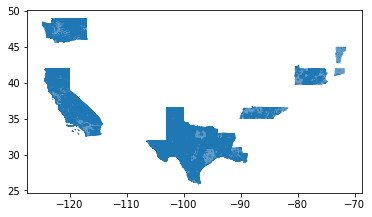

In [43]:
f, ax = plt.subplots()
census_data_geoms_gdf.plot(ax=ax)

## *Can later come in and determine which census tracts can be removed via spatial join clipping*

## Convert census data into percentages

In [44]:
census_data_geoms_gdf["PctBelowPoverty"] = census_data_geoms_gdf["PopulationBelowPovertyLevel"]/census_data_geoms_gdf["TotalPopulation"]
census_data_geoms_gdf["PctWhite"] = census_data_geoms_gdf["PopulationWhiteAlone"]/census_data_geoms_gdf["TotalPopulation"]
census_data_geoms_gdf["PctBlack"] = census_data_geoms_gdf["PopulationBlackAlone"]/census_data_geoms_gdf["TotalPopulation"]
census_data_geoms_gdf["PctIndigenous"] = (census_data_geoms_gdf["PopulationAmericanIndianAlaskaNativeAlone"] + census_data_geoms_gdf["PopulationNativeHawaiianPacificIslanderAlone"])/census_data_geoms_gdf["TotalPopulation"]
census_data_geoms_gdf["PctAsian"] = census_data_geoms_gdf["PopulationAsianAlone"]/census_data_geoms_gdf["TotalPopulation"]
census_data_geoms_gdf["PctHispanic"] = census_data_geoms_gdf["PopulationHispanic"]/census_data_geoms_gdf["TotalPopulation"]
census_data_geoms_gdf["PctBIPOC"] = 1 - census_data_geoms_gdf["PctWhite"]
census_data_geoms_gdf["PctMale"] = census_data_geoms_gdf["PopulationMale"]/census_data_geoms_gdf["TotalPopulation"]
census_data_geoms_gdf["PctBachelors"] = census_data_geoms_gdf["BachelorsEdPopulation25+"]/census_data_geoms_gdf["TotalPopulation25+"]

In [51]:
# replace state code with state name
census_data_geoms_gdf["State"] = census_data_geoms_gdf["State"].apply(lambda x: states[x])

/Users/kaitlynng/opt/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [53]:
census_data_geoms_gdf = census_data_geoms_gdf[['Name', 'State', 'PctWhite', 'PctBlack', 'PctIndigenous', 'PctAsian', 'PctHispanic', 'PctBIPOC', 'PctMale', 'TotalPopulation', 'MedianAge', 'MedianIncome', 'PctBelowPoverty', 'PctBachelors', 'geometry']]
census_data_geoms_gdf

,Name,State,PctWhite,PctBlack,PctIndigenous,PctAsian,PctHispanic,PctBIPOC,PctMale,TotalPopulation,MedianAge,MedianIncome,PctBelowPoverty,PctBachelors,geometry
Tract,,,,,,,,,,,,,,,
507904,"Census Tract 5079.04, Santa Clara County, Cali...",California,0.279186,0.000000,0.019718,0.656338,0.032864,0.720814,0.474178,3195,47.2,206607,0.000000,0.293988,"POLYGON ((-122.00785 37.29334, -122.00770 37.2..."
508504,"Census Tract 5085.04, Santa Clara County, Cali...",California,0.276499,0.010344,0.000000,0.574152,0.158415,0.723501,0.513366,8604,31.3,114300,0.093677,0.355136,"POLYGON ((-122.03212 37.36770, -122.03209 37.3..."
508505,"Census Tract 5085.05, Santa Clara County, Cali...",California,0.451858,0.002464,0.003901,0.485732,0.085403,0.548142,0.471566,4871,38.4,152969,0.077397,0.368618,"POLYGON ((-122.01410 37.36446, -122.01406 37.3..."
508704,"Census Tract 5087.04, Santa Clara County, Cali...",California,0.395281,0.043100,0.003032,0.472782,0.196520,0.604719,0.565704,7587,31.3,145500,0.060498,0.317588,"POLYGON ((-122.03358 37.37965, -122.03354 37.3..."
509403,"Census Tract 5094.03, Santa Clara County, Cali...",California,0.393494,0.023880,0.007095,0.314068,0.342620,0.606506,0.559266,5779,28.9,112278,0.160927,0.233485,"POLYGON ((-122.10193 37.39575, -122.10188 37.3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
041005,"Census Tract 410.05, Clark County, Washington",Washington,0.713691,0.073242,0.012068,0.013317,0.208073,0.286309,0.431128,2403,32.5,42639,0.177278,0.084552,"POLYGON ((-122.77411 45.68424, -122.77303 45.6..."
029204,"Census Tract 292.04, King County, Washington",Washington,0.462617,0.118769,0.005192,0.173416,0.229751,0.537383,0.487020,7704,27.7,74097,0.143692,0.198061,"POLYGON ((-122.23109 47.38788, -122.23109 47.3..."
029305,"Census Tract 293.05, King County, Washington",Washington,0.454872,0.112282,0.000000,0.320326,0.082116,0.545128,0.524300,4177,40.4,105579,0.039502,0.273688,"POLYGON ((-122.22131 47.42516, -122.22128 47.4..."


In [54]:
# this took 4.5 mins to download...beware!
# census_data_geoms_gdf.to_file("census_data_geoms_gdf.shp")

/var/folders/mg/5x982c514sl0dc5v1pd9gj580000gn/T/ipykernel_19743/3069461680.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  census_data_geoms_gdf.to_file("census_data_geoms_gdf.shp")
